In [1]:
!pip install split-folders

In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import splitfolders

from warnings import filterwarnings as fws
fws('ignore')

In [3]:
ROOT = '/kaggle/input/ricediseasedataset/FINAL_DATASETS/CLASSIFICATION DATASET'
splitfolders.ratio(ROOT, output="output", seed=143, ratio=(.9, 0,0.1))

Copying files: 1286 files [00:05, 218.74 files/s]


In [4]:
root_dir = '/kaggle/working/output/train'
class_list = os.listdir(root_dir)

paths = []
classes = []

for class_name in class_list:
    class_dir = os.path.join(root_dir, class_name)
    for subdir, dirs, files in os.walk(class_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            paths.append(file_path)
            classes.append(class_name)

df = pd.DataFrame({'path': paths, 'class': classes})
df['class_num'] = df['class'].astype('category').cat.codes
df

,path,class,class_num
0,/kaggle/working/output/train/bacterial_blight/...,bacterial_blight,0
1,/kaggle/working/output/train/bacterial_blight/...,bacterial_blight,0
2,/kaggle/working/output/train/bacterial_blight/...,bacterial_blight,0
3,/kaggle/working/output/train/bacterial_blight/...,bacterial_blight,0
4,/kaggle/working/output/train/bacterial_blight/...,bacterial_blight,0
...,...,...,...
1150,/kaggle/working/output/train/tungro_virus/55.jpg,tungro_virus,3
1151,/kaggle/working/output/train/tungro_virus/remo...,tungro_virus,3
1152,/kaggle/working/output/train/tungro_virus/44.jpg,tungro_virus,3
1153,/kaggle/working/output/train/tungro_virus/remo...,tungro_virus,3


Text(0.5, 1.0, 'Class Distribution')

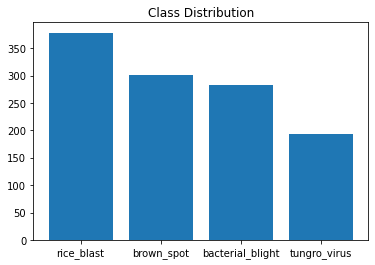

In [5]:
class_dict = {'bacterial_blight':'0', 'brown_spot':'1', 'rice_blast':'2', 'tungro_virus':'3'}

_ = df['class'].value_counts()
plt.bar(x=_.index, height=_.values)
plt.title('Class Distribution')

In [10]:
from albumentations import (
    Compose,
    RandomRotate90,
    Flip,
    Transpose,
    RandomSizedCrop,
    RandomBrightnessContrast,
    RandomGamma,
    Rotate
)

def augment(image):
    augmentations = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.5),
        Rotate()
    ])

    augmented = augmentations(image=image)
    image = augmented['image']

    return image

In [42]:
def canny_overlay(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges = cv2.dilate(edges, kernel, iterations=1)
    return cv2.addWeighted(image, 0.7, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR, 255), 0.3, 0)

In [46]:
augmented_images, labels = [], []
for image, class_ in tqdm_notebook(zip(df['path'], df['class_num'])):
    
    for _ in range(2):
        aug_img = cv2.imread(image)
        aug_img = cv2.resize(aug_img, (256, 256))
        aug_img = canny_overlay(aug_img)
        aug_img = cv2.normalize(aug_img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        

        augmented_images.append(augment(aug_img))
        labels.append(class_)

0it [00:00, ?it/s]

In [47]:
X = np.array(augmented_images)
y = np.array(labels)

print('x_min', X.min())
print('x_max', X.max())
print('y_min', y.min())
print('y_max', y.max(), '\n')
print(X.shape)
print(y.shape)

x_min 0.0
x_max 1.0
y_min 0
y_max 3 

(2310, 256, 256, 3)
(2310,)


In [48]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import MobileNet, MobileNetV2, DenseNet121, DenseNet201,DenseNet169
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras import regularizers

In [49]:
num_classes = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=143)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [50]:
base_model = DenseNet169(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

2023-01-28 07:24:50.066375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 07:24:50.162998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 07:24:50.164048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 07:24:50.165511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________

In [51]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
filepath = "MobileNetV2-v4.h5"

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[checkpoint])

2023-01-28 07:25:10.180528: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1453326336 exceeds 10% of free system memory.
2023-01-28 07:25:11.811953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1453326336 exceeds 10% of free system memory.
2023-01-28 07:25:13.020962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-28 07:25:22.141528: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 26s 188ms/step - loss: 6.1135 - accuracy: 0.6201 - val_loss: 2.7328 - val_accuracy: 0.7532

Epoch 00001: val_accuracy improved from -inf to 0.75325, saving model to MobileNetV2-v4.h5
Epoch 2/100
58/58 [==============================] - 7s 114ms/step - loss: 2.1868 - accuracy: 0.7527 - val_loss: 1.7055 - val_accuracy: 0.8009

Epoch 00002: val_accuracy improved from 0.75325 to 0.80087, saving model to MobileNetV2-v4.h5
Epoch 3/100
58/58 [==============================] - 7s 113ms/step - loss: 1.4645 - accuracy: 0.8068 - val_loss: 1.2338 - val_accuracy: 0.8312

Epoch 00003: val_accuracy improved from 0.80087 to 0.83117, saving model to MobileNetV2-v4.h5
Epoch 4/100
58/58 [==============================] - 6s 111ms/step - loss: 1.1846 - accuracy: 0.8019 - val_loss: 1.0278 - val_accuracy: 0.8723

Epoch 00004: val_accuracy improved from 0.83117 to 0.87229, saving model to MobileNetV2-v4.h5
Epoch 5/100
58/58 [==============================] - 6s 111ms/

In [52]:
import pandas as pd

results_df = pd.DataFrame(history.history)
results_df.to_csv('89_DenseNet169.csv', index=False)
results_df

,loss,accuracy,val_loss,val_accuracy
0,6.113499,0.620130,2.732775,0.753247
1,2.186823,0.752706,1.705542,0.800866
2,1.464502,0.806818,1.233816,0.831169
3,1.184607,0.801948,1.027830,0.872294
4,1.030331,0.819805,0.912110,0.854978
...,...,...,...,...
95,0.535864,0.895563,0.568954,0.889610
96,0.533150,0.901515,0.621719,0.839827
97,0.562056,0.879329,0.583714,0.883117
98,0.547243,0.896645,0.578848,0.880952


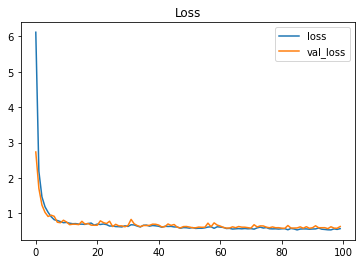

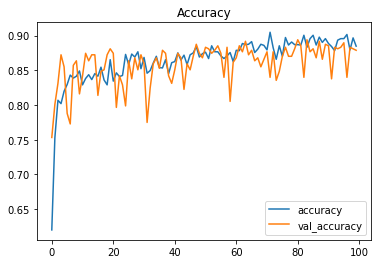

In [53]:
results_df['loss'].plot()
results_df['val_loss'].plot()
plt.title('Loss')
plt.legend()
plt.show()

results_df['accuracy'].plot()
results_df['val_accuracy'].plot()
plt.title('Accuracy')
plt.legend()
plt.show()

In [54]:
test_dir = '/kaggle/working/output/test'
class_list = os.listdir(test_dir)

test_paths = []
test_classes = []

for class_name in class_list:
    class_dir = os.path.join(test_dir, class_name)
    for subdir, dirs, files in os.walk(class_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            test_paths.append(file_path)
            test_classes.append(class_name)

test_df = pd.DataFrame({'path': test_paths, 'class': test_classes})
test_df['class_num'] = test_df['class'].astype('category').cat.codes
test_df

,path,class,class_num
0,/kaggle/working/output/test/bacterial_blight/r...,bacterial_blight,0
1,/kaggle/working/output/test/bacterial_blight/1...,bacterial_blight,0
2,/kaggle/working/output/test/bacterial_blight/r...,bacterial_blight,0
3,/kaggle/working/output/test/bacterial_blight/1...,bacterial_blight,0
4,/kaggle/working/output/test/bacterial_blight/r...,bacterial_blight,0
...,...,...,...
126,/kaggle/working/output/test/tungro_virus/remov...,tungro_virus,3
127,/kaggle/working/output/test/tungro_virus/135.jpg,tungro_virus,3
128,/kaggle/working/output/test/tungro_virus/120.jpg,tungro_virus,3
129,/kaggle/working/output/test/tungro_virus/remov...,tungro_virus,3


In [55]:
test_images = []

for i in test_df['path']:
    in_data = cv2.normalize(cv2.imread(i),None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    test_images.append(np.expand_dims(in_data, axis=0))

In [56]:
y_pred = [model.predict(i).argmax() for i in tqdm_notebook(test_images)]

  0%|          | 0/131 [00:00<?, ?it/s]

In [57]:
from sklearn.metrics import classification_report
print(classification_report(test_df['class_num'].values.tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.75      0.28      0.41        32
           1       0.63      0.76      0.69        34
           2       0.62      0.70      0.66        43
           3       0.67      0.91      0.77        22

    accuracy                           0.65       131
   macro avg       0.67      0.66      0.63       131
weighted avg       0.66      0.65      0.63       131

